<div class="notebook-buttons" style="display:flex; padding-top: 5rem;padding-bottom: 2.5rem;line-height: 2.15;">
    <a href="https://colab.research.google.com/github/magdasalatka/fantastic-features/blob/main/main.ipynb">
        <div id="colab-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; align-items: center;">
            <img class="call-to-action-img" src="img/colab.svg" width="30" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Run in Google Colab</div>
        </div>
    </a>
    <a href="https://raw.githubusercontent.com/magdasalatka/fantastic-features/main/main.ipynb" download>
        <div id="download-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/download.svg" width="22" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Download Notebook</div>
        </div>
    </a>
    <a href="https://github.com/magdasalatka/fantastic-features/blob/main/main.ipynb">
        <div id="github-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/github.svg" width="25" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">View on GitHub</div>
        </div>
    </a>
</div>

# Back to the Feature
### Statistical feature engineering

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as sg
from typing import Tuple, List, Optional
import math


C:\Users\TK\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.datasets import make_regression
from dataset_noise_generator import *

# 1. Load data 

Option 1: load predefined dataset: 

In [3]:
X, y = datasets.load_diabetes(return_X_y=True)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (442, 10)
y shape: (442,)


Option 2: work with a synthetic dataset: 
- sklearn's `make_regression`
- modified version of `make_regression` that takes coefficients as an input 
- your own generated data (e.g. containing coupled variables, polynomial/non-linear relations etc.)

In [46]:
num_indep = 3
n_sample = 1000

X_base, y_base, coeffs = make_regression_custom(n_samples=n_sample, n_features=num_indep, n_informative=num_indep,
                       tail_strength=0, bias=0, n_targets=1, noise=0, 
                           shuffle=False, coef=True, random_state=2, custom_coef=[30,15,20])
noise = gen_noise(X_base, 0.1, 'sin', n_osc=3)+gen_noise(X_base, 0.1, 'normal')
X = X_base + noise

noise_y = gen_noise(y_base, 15, 'normal')*gen_noise(y_base, 0.1, 'linear_inc')
y = y_base + noise_y


In [47]:
y_base.shape

(1000,)

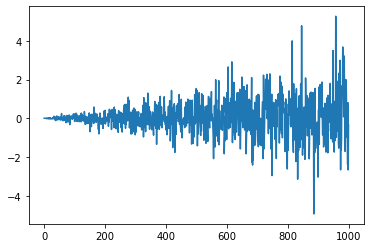

In [48]:
plt.plot(noise_y)

Train-test split

In [49]:
threshold = int(len(X)*0.8)
X_train, X_test = X[:threshold], X[threshold:]
y_train, y_test = y[:threshold], y[threshold:]

# 2. Fit regression

## 2.1 Inspect data
How does the data look like?

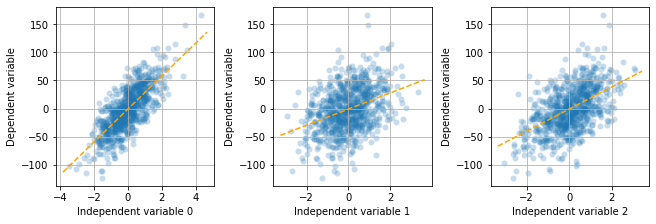

In [50]:
def plot_multiple_x_vs_y(X: np.ndarray, y: np.ndarray, x_name: str, y_name: str, 
                         add_regression_line: bool = True, add_zero_line: bool =False, 
                         model = None, hexbin: bool = False, n_col:int = 2,
                         figsize = None) -> None:

    if add_regression_line and (model is None):
        predictors = sm.add_constant(X)
        model = sm.OLS(y_train, predictors).fit()

    
    n_vars = X.shape[1]
    n_row = math.ceil(n_vars/n_col)
    if figsize is None: 
        subplot_size = (3,3)
        figsize = (n_col*subplot_size[0], n_row*subplot_size[1])
    _, axs = plt.subplots(n_row, n_col, figsize=figsize, constrained_layout=True)


    for i, x in enumerate(X.T):
        row = i//n_col
        col = i%n_col
      
        if n_row == 1: 
            this_ax = axs[col]
        else: 
            this_ax = axs[row,col]
        
        if hexbin: 
            this_ax.hexbin(x, y, cmap="Greys", gridsize=40)
        else: 
            this_ax.scatter(x, y, alpha=0.25, lw=0)
        this_ax.set_xlabel("{} {}".format(x_name, i))
        this_ax.set_ylabel(y_name)
        this_ax.grid(True)
        if add_zero_line:
            this_ax.hlines(0, xmin=min(x), xmax=max(x), colors="magenta")

        if add_regression_line:
            x_vals = np.array(this_ax.get_xlim())
            y_vals = model.params[0] + model.params[i+1] * x_vals
            this_ax.plot(x_vals, y_vals, '--', color="orange")

plot_multiple_x_vs_y(X_train, y_train, "Independent variable", "Dependent variable", 
                     add_regression_line=True, hexbin=False, n_col=3)

## 2.2 Fitting the model

In [51]:
# Scikit-learn version => No summary table
#lm = linear_model.LinearRegression()
#model = lm.fit(X_train, y_train)
#fitted = model.predict(X_train)

predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
fitted = model.predict(predictors)

## 2.3 Analysing model output

In [52]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.105e+04
Date:                Sat, 16 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:40:25   Log-Likelihood:                -2572.1
No. Observations:                 800   AIC:                             5152.
Df Residuals:                     796   BIC:                             5171.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8940      0.214     -4.179      0.0

Working with Statsmodels output table: 

In [53]:
model.pvalues

array([3.25453811e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [54]:
model.params

array([-0.89402677, 29.2040656 , 14.32884147, 19.670654  ])

In [55]:
# compare with our coeffs: 
coeffs

array([30., 15., 20.])

In [56]:
# export the table to pandas dataframe using .summary2(); _.tables is a tuple of 3 sub-tables, each of them is a df 
model.summary2().tables

[                     0                 1                    2          3
 0               Model:               OLS      Adj. R-squared:      0.976
 1  Dependent Variable:                 y                 AIC:  5152.1334
 2                Date:  2021-10-16 17:40                 BIC:  5170.8718
 3    No. Observations:               800      Log-Likelihood:    -2572.1
 4            Df Model:                 3         F-statistic:  1.105e+04
 5        Df Residuals:               796  Prob (F-statistic):       0.00
 6           R-squared:             0.977               Scale:     36.500,
            Coef.  Std.Err.           t     P>|t|     [0.025     0.975]
 const  -0.894027  0.213942   -4.178836  0.000033  -1.313983  -0.474070
 x1     29.204066  0.213337  136.891805  0.000000  28.785296  29.622835
 x2     14.328841  0.214670   66.748071  0.000000  13.907454  14.750229
 x3     19.670654  0.210701   93.358159  0.000000  19.257059  20.084249,
                 0      1                  2  

In [57]:
# .summary2() not always stable, a workaround is below, but then you lose some digits after comma:  
pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.8940,0.214,-4.179,0.0,-1.314,-0.474
x1,29.2041,0.213,136.892,0.0,28.785,29.623
x2,14.3288,0.215,66.748,0.0,13.907,14.750
x3,19.6707,0.211,93.358,0.0,19.257,20.084


## 2.4 Actual vs predicted

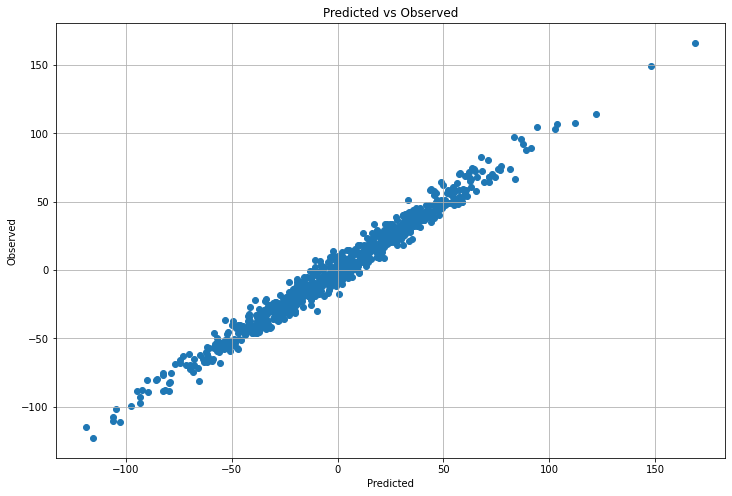

In [58]:
def plot_x_vs_y(x: np.ndarray, y: np.ndarray, x_name: str, y_name: str, add_zero_line: bool =False) -> None:
    _, ax = plt.subplots(figsize=(12,8))
    ax.scatter(x, y)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.grid(True)
    if add_zero_line:
        plt.hlines(0, xmin=min(fitted), xmax=max(fitted), colors="orange")
    plt.title("{} vs {}".format(x_name, y_name))


plot_x_vs_y(fitted, y_train, "Predicted", "Observed")

# 3. Regression diagnostics

Regression has some assumptions about its errors, *e<sub>i</sub>*. 
These assumptions are:

 * E[*e<sub>i</sub>*] = 0
 * Var(*e<sub>i</sub>*) = &sigma;<sup>2</sup>
 * *e<sub>i</sub>* ~ *N*(0, &sigma;<sup>2</sup>)
 * Cov(*e<sub>i</sub>*, *e<sub>j</sub>*) = 0

 Additioanlly, we also assume:
 * no multicollinearity in regressors
ity

The first three conditions are necessary to perform a least square estimation and to have valid fitted values.
The last condition is only required for any hypothesis tests, confidence intervals and prediction intervals. 


As you can see, most of our assumptions are about errors. However, errors cannot be observed in practice. Instead, we well be working with residuals, which are only estimates of the errors. They have however, an estimation-related issue.

In regression, the variances of the residuals at different input variable values may differ. This can happen even if the variances of the errors at these different input variable values are equal.

To improve the results, we can standardize or [studentize](https://en.wikipedia.org/wiki/Studentized_residual) the residuals.

## 3.1 Assumption 1
E[*e<sub>i</sub>*] = 0

In other words, on average the errrors should be zero

In [59]:
residuals_raw = fitted - y_train
residuals = residuals_raw/np.std(residuals_raw)
print("Expected error estimate: {}".format(sum(residuals)/len(residuals)))

Expected error estimate: -1.3328227410625005e-15


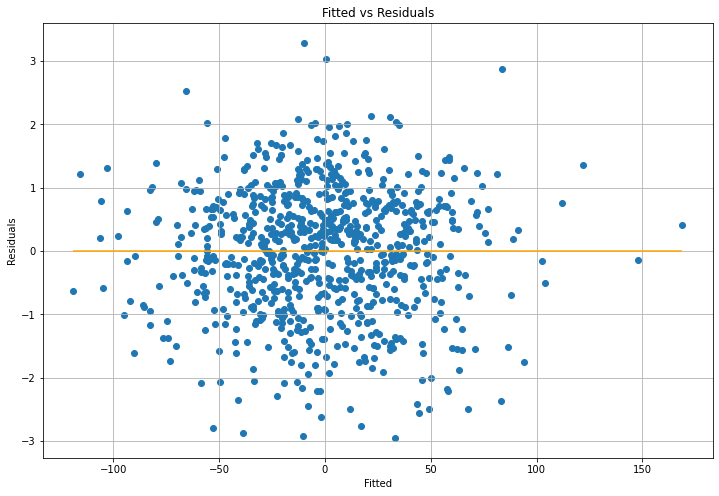

In [60]:
plot_x_vs_y(fitted, residuals, "Fitted", "Residuals", True)

Failing assumption implies systematic error. This means:
* the relationship between response and regressors may be nonlinear
* some important regressors may be missing
* some important interactions may be missing

To try:
* transform regressor(s)
* create new variables (e.g. higher order, interaction terms)
* In practice: find new, relevant data (business knowledge)
* use nonlinear model  -> DO NOT transform response

## 3.2 Assumption 2

Var(*e<sub>i</sub>*) = &sigma;<sup>2</sup>

In other words: variance of residuals should be constant

### 3.1 Fitted vs residuals: heteroskedasticity check

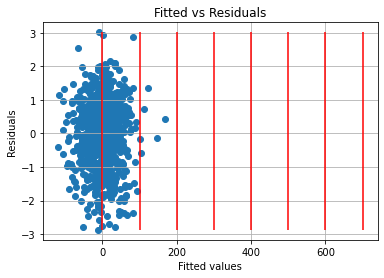

In [31]:
# Let's extend our plot_fitted_vs_residuals function
def plot_fitted_vs_residuals(fitted: np.ndarray, residuals: np.ndarray, 
                             mean: bool=True, 
                             window: Optional[int]= None) -> None:

    _, ax = plt.subplots()
    plt.grid(True)
    plt.scatter(fitted, residuals)
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    if mean:
        plt.hlines(0, xmin=min(fitted), xmax=max(fitted), colors="orange")
    if window:
        plt.vlines(range(0, len(fitted), window), ymin=min(residuals), ymax=max(residuals), colors="red")
    plt.title('Fitted vs Residuals')

plot_fitted_vs_residuals(fitted, residuals, False, window=100)

### 3.2 Residuals: heteroskedasticity check

In [32]:
def calculate_variances(fitted: np.ndarray, residuals: np.ndarray, window: int) -> List[float]:
    sorted_residuals = [x for _, x in sorted(zip(fitted, residuals))]

    start = 0
    variances = []
    while start+window < len(sorted_residuals):
        variances.append(np.var(sorted_residuals[start:start+window]))
        start += window

    # TODO: check if np.var is sample variance
    variances[-1] = np.var(sorted_residuals[start-window:])
    return variances

# TODO: Try different windows
variances = calculate_variances(fitted, residuals, 100)
for v in variances:
    print(v)

0.8927076163662726
0.8410523671688678
0.8270212906312817
1.325702261045644
0.942306017855379
1.0149306266776563
1.0367706340223528


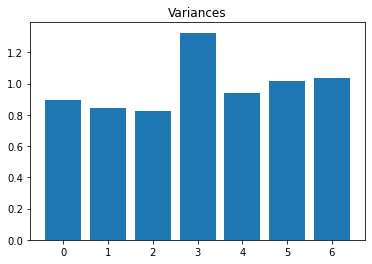

In [33]:
plt.bar(range(len(variances)), variances)
plt.title('Variances')
plt.show()

Failing assumption implies heteroskedasticity. This means:
* the error estimates are not valid =>
* the confidence intervals are not valid =>
* p-values are not valid
* coefficients **are valid**  

In short: your expected value remains unchanged. But you have no viable insights on model unsertanity.

To try:
* transform regressor(s)
* create new variables (e.g. dummy variables for low/high values, bucketing)


If non-constant variance is expected:
use weighted regression

## 3.3 Assumption 3
*e<sub>i</sub>* ~ *N*(0, &sigma;<sup>2</sup>)

In other words: residuals are normally distributed

### 3.1 Empirical distribution

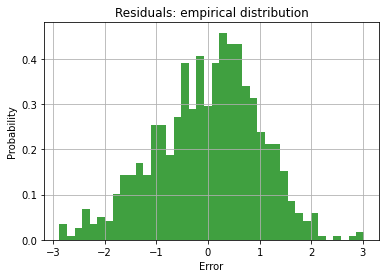

In [34]:
def plot_residuals_distribution(residuals: np.ndarray, bins:int=50) -> None:
    plt.hist(residuals, bins, density=True, facecolor='g', alpha=0.75)

    plt.xlabel('Error')
    plt.ylabel('Probability')
    plt.title('Residuals: empirical distribution')
    plt.grid(True)
    plt.show()

plot_residuals_distribution(residuals, 40)

### 3.2 QQ-plot

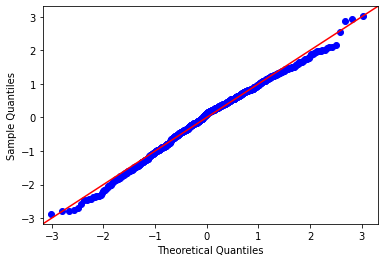

In [35]:
fig = sm.qqplot(residuals/np.std(residuals), line='45')

Failing assumption implies systematic deviation. This means:
* model is failing to capture certain range of values
* model structure is not correct

In practice:
* few data points that are slightly "off the line" near the ends common, and usually tolerable
* skewed residuals need correction
* long-tailed, but symmetrical residuals are can be tolerable


To try:
* transform regressors
* long-tails => robust regression

## 3.4 Assumption 4
Cov(*e<sub>i</sub>*, *e<sub>j</sub>*) = 0

In other words: errors are not correlated **WITH EACH OTHER**


### 4.1 Residuals over time

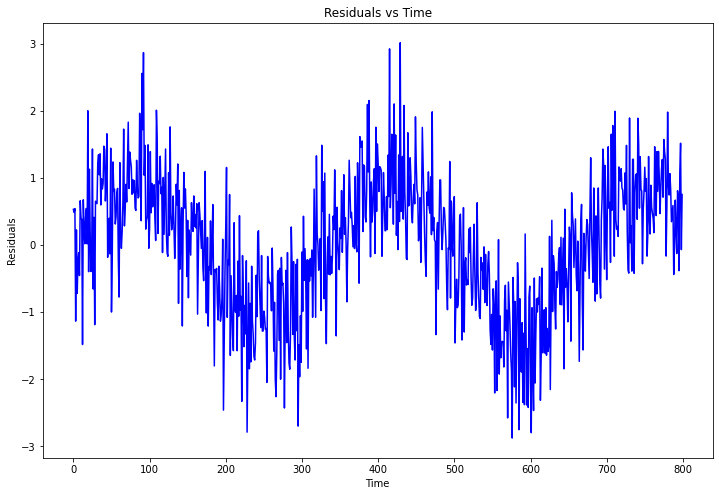

In [36]:
def plot_x_over_time(x: np.ndarray, x_name: str) -> None:

    _, ax = plt.subplots(figsize=(12,8))
    ax.set_xlabel("Time")
    ax.set_ylabel(x_name)
    ax.plot(range(len(x)), x, 'b-')
    plt.title("{} vs Time".format(x_name))
    plt.show()

plot_x_over_time(residuals, "Residuals")

### 4.2 ACF plot
Check residuals vs lagged residuals

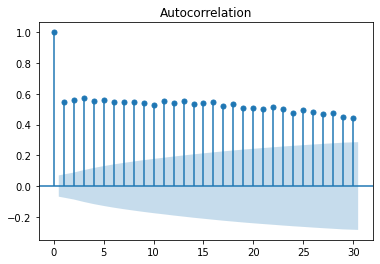

In [37]:
fig = sg.tsaplots.plot_acf(residuals)

### 4.3 Residuals vs independent variables

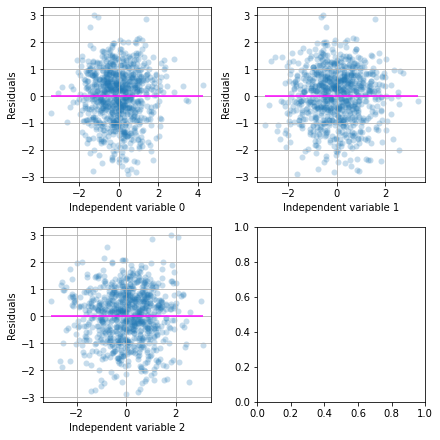

In [38]:
plot_multiple_x_vs_y(X_train, residuals, "Independent variable", "Residuals", False, True)

Failing assumption means:
* estimates are unbiased => expected value for coefficients and predictions is ok
* the estimate is not efficient => there are better regression models 
* standard errors are biased => confidence intervals, test statistics, and p-values are flawed

To try:
* look for "forgotten" regressors => time, order etc.
* use Generalized Least Squares
* when appropriate, use time series models


## Assumption 5 (Optional)
No multicollinearlty

Regression does not have a unique solution if regressors are exactly linearly dependent. Often, we will find not perfect, but a strong correlation between variables. Multicollinearity means that there is such strong, yet not perfect, relation between the columns of X.

Under multicollinity, unique solution exists. However, it performs poorly in practice. 

### 5.1 Correlation plot

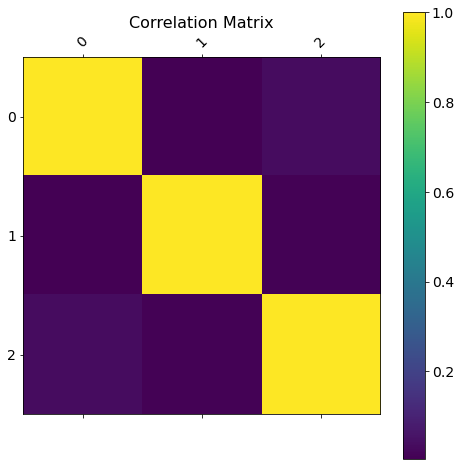

In [39]:
def plot_correlations(X: np.ndarray) -> None:
    df = pd.DataFrame(X)

    f = plt.figure(figsize=(8, 8))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

plot_correlations(X_train)

Multicollinearlity means:
* estimated coefficients have large standard errors
* the coefficients are imprecise
* it happens that none of the regressors is significant!
* small change in data can result in big change in results

To try:
* amputation
* creating new variables
* Ridge/lasso regression

## 6 Summary

You can plot residuals agains any variable. We can compare it to fitted value, but also to regressors we used, or the ones we are considering. 
No matter what the residuals are plotted against, there cannot be **any non-random structure**. 

Any observed strucure means model has defficiencies, and needs improvement.